# Different number of channels result

In [1]:
from optical_flax.dsp import simple_dsp, mimo_dsp
from optical_flax.generate_data import get_data
import matplotlib.pyplot as plt
import optical_flax.base as base
import optax
from collections import namedtuple
from gdbp import gdbp_base as gb, data as gdat, aux
import pickle


## EX1: MIMO_DSP + channels = [7,13,19,25]

In [2]:
## mimo_dsp  + sml_data
N = [7, 13, 19, 25]
print('mimo dsp for different channels:')
ber_mimodsp = []
for i in range(4):
    path = f'data/data0426_N4e5/dataset_ch{N[i]}_dz0.5_N4e5'
    data_sml = get_data(path,sps=2)
    data = data_sml
    sig_list, name, metric = mimo_dsp(data)
    ber_mimodsp.append(metric['BER']['total'])
    print(f'Result for channels = {N[i]}')
    print(metric)
    print(' ')

mimo dsp for different channels:
Result for channels = 7
           BER       QSq        SNR
dim0   0.00081  9.972500  16.866356
dim1   0.00093  9.860014  16.889726
total  0.00087  9.914654  16.878018
 
Result for channels = 13
            BER       QSq        SNR
dim0   0.001900  9.230883  16.049120
dim1   0.002010  9.177553  16.001791
total  0.001955  9.203918  16.025410
 
Result for channels = 19
            BER       QSq        SNR
dim0   0.008185  7.606252  14.321764
dim1   0.008185  7.606252  14.357932
total  0.008185  7.606252  14.339808
 
Result for channels = 25
            BER       QSq        SNR
dim0   0.023340  5.973535  12.598231
dim1   0.023305  5.976306  12.579689
total  0.023322  5.974920  12.588975
 


## Ex2: Train NN + different channels

In [4]:
## NN DSP  + sml_data
N = [7, 13, 19, 25]
ber_NN = []
for i in range(4):
    train_path = f'data/data0426_N4e5/dataset_ch{N[i]}_dz0.5_N4e5'
    test_path = f'data/data0426_N4e5/dataset_ch{N[i]}_dz0.5_N4e5'
    data_train = get_data(train_path, sps=2)
    data_test = get_data(test_path, sps=2)
    
    ## Training FDBP Model on a signal 
    from commplax import optim 
    lr = optim.piecewise_constant([500, 1000], [1e-4, 1e-5, 1e-6])
    tx = optax.adam(learning_rate=lr)

    ## define model
    batch_size = 500
    sparams_flatkeys = []  # [('DBP',),('RConv',)] static parameters
    model_train = base.model_init(data_train, sparams_flatkeys=sparams_flatkeys, mode='train')  
    model_test = base.model_init(data_test, sparams_flatkeys=sparams_flatkeys, mode='test')  

    # train model
    gen = base.train(model_train, data_train, batch_size=500, n_iter=2000, tx=tx)
    loss0, Train0 = base.run_result(gen)

    # test model
    metric,sig_list = base.test(model_test, Train0[-1].params, data_test, eval_range=(30000,-20000))
    ber_NN.append(metric['BER']['total'])

    print(f'Result for channels = {N[i]}')
    print(metric)
    print(' ')

Result for channels = 7
            BER        QSq        SNR
dim0   0.000348  10.606033  17.621527
dim1   0.000364  10.576056  17.630904
total  0.000356  10.590910  17.626209
 


Result for channels = 13
            BER       QSq        SNR
dim0   0.000818  9.964489  16.794879
dim1   0.000949  9.842970  16.785688
total  0.000884  9.901865  16.790284
 


Result for channels = 19
            BER       QSq        SNR
dim0   0.005166  8.180073  14.896514
dim1   0.005126  8.189292  14.897560
total  0.005146  8.184676  14.897038
 


Result for channels = 25
            BER       QSq        SNR
dim0   0.016534  6.572747  13.169755
dim1   0.016104  6.615614  13.136768
total  0.016319  6.594086  13.153274
 


## Ex 3: Meta + different channels

In [6]:
## NN DSP  + sml_data
N = [7, 13, 19, 25]
ber_meta = []
for i in range(4):
    train_path = f'data/data0426_N4e5/dataset_ch{N[i]}_dz0.5_N4e5'
    test_path = f'data/data0426_N4e5/dataset_ch{N[i]}_dz0.5_N4e5'
    data_train = get_data(train_path, sps=2)
    data_test = get_data(test_path, sps=2)

    ## Training Meta_DBP Model on a signal 
    from optical_flax.layers import MetaSSFM, GRU_DBP, fdbp
    from commplax import optim 
    lr = optim.piecewise_constant([500, 1000], [1e-3, 1e-5, 1e-6])
    tx = optax.adam(learning_rate=lr)

    ## define model
    batch_size = 500
    sparams_flatkeys = []  # [('FDBP',),('RConv',)] static parameters
    model = base.model_init(data_train, init_len = 1990, sparams_flatkeys=sparams_flatkeys,domain='frequency',GDBP=MetaSSFM, dtaps=1990, ntaps=1)  
    model_test = base.model_init(data_test,init_len = 1990, sparams_flatkeys=sparams_flatkeys,domain='frequency',GDBP=MetaSSFM, dtaps=1990, ntaps=1, mode='test') 

    # train model
    gen = base.train(model, data_test, batch_size=500, n_iter=2000, tx=tx)
    loss1, Train1 = base.run_result(gen)

    # # saving result
    # with open('sml_data/MetaTrain_loss_state_smldata','wb') as file:
    #     pickle.dump((loss1, Train1[-1]), file)

    # # load result
    # with open('sml_data/MetaTrain_loss_state_smldata','rb') as file:
    #     loss1, train_state = pickle.load(file)

    # test model
    metric, metric_list,res_list = base.test_meta(model_test, Train1[-1].params, data_test)
    ber_meta.append(metric['BER']['total'])

    print(f'Result for channels = {N[i]}')
    print(metric)
    print(' ')

Result for channels = 7
            BER  QSq        SNR
dim0   0.001410  NaN  17.399600
dim1   0.001412  NaN  17.424011
total  0.001411  NaN  17.405957
 


Result for channels = 13
            BER  QSq        SNR
dim0   0.002107  inf  16.663222
dim1   0.002087  NaN  16.670786
total  0.002097  inf  16.662714
 


Result for channels = 19
            BER       QSq        SNR
dim0   0.006511  8.210353  14.834815
dim1   0.006042       inf  14.883813
total  0.006276  8.215541  14.856435
 


Result for channels = 25
            BER       QSq        SNR
dim0   0.019650  6.396022  12.891308
dim1   0.018854  6.448151  12.935216
total  0.019252  6.411669  12.909143
 


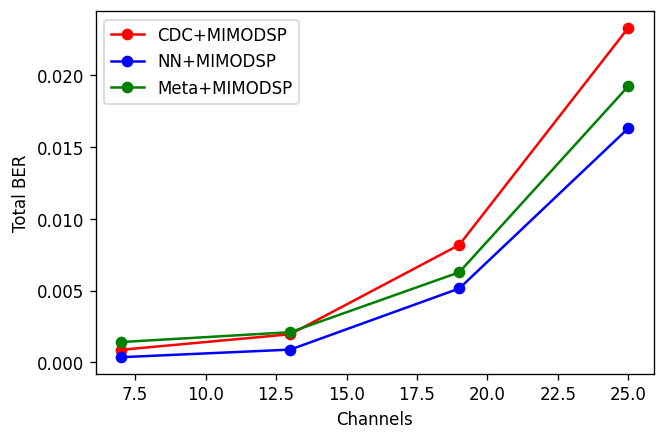

In [7]:
plt.figure(dpi=120)
plt.plot(N, ber_mimodsp, '-o', color='r', label='CDC+MIMODSP')
plt.plot(N, ber_NN, '-o', color='b', label='NN+MIMODSP')
plt.plot(N, ber_meta, '-o', color='g', label='Meta+MIMODSP')
plt.xlabel('Channels')
plt.ylabel('Total BER')
plt.legend()

## 2021DSP + simulation data + debug

In [70]:
from optical_flax.dsp import simple_dsp, mimo_dsp
import matplotlib.pyplot as plt
import optical_flax.base as base
import optax
from collections import namedtuple
from gdbp import gdbp_base as gb, data as gdat, aux
import pickle
import numpy as np
Input = namedtuple('DataInput', ['y', 'x', 'w0', 'a'])

## real data
# data_train = gdat.load(1, 0, 4, 2)[0]
# data_test = gdat.load(2, 0, 4, 2)[0]

## simulation data
path1 = 'sml_data/dataset_ch7_dz15_0413night'
path2 = f'test_data/dataset_ch{7}_dz5_N4e5'
with open(path2, 'rb') as file:
    b = pickle.load(file)
    data_sml = Input(b[0],b[1],-b[2],b[3])  # w0 计算有点错误（搞错了符号）

In [71]:
## Training FDBP Model on a signal 
from commplax import optim 
lr = optim.piecewise_constant([500, 1000], [1e-4, 1e-5, 1e-6])
tx = optax.adam(learning_rate=lr)

## define model
batch_size = 500
sparams_flatkeys = []  # [('DBP',),('RConv',)] static parameters
model_train = base.model_init(data_sml, sparams_flatkeys=sparams_flatkeys, mode='train')  
model_test = base.model_init(data_sml, sparams_flatkeys=sparams_flatkeys, mode='test')  

# train model
gen = base.train(model_train, data_sml, batch_size=500, n_iter=2000, tx=tx)
loss0, Train0 = base.run_result(gen)

# test model
metric,sig_list = base.test(model_test, Train0[-1].params, data_sml, eval_range=(30000,-20000))


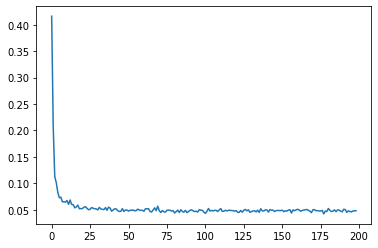

In [72]:
plt.plot(loss0[:100])

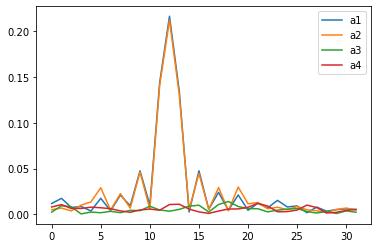

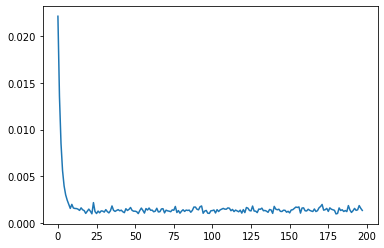

In [57]:
## 展示 train state
num = 2
a1 = Train0[num].state['af_state']['MIMOAF']['mimoaf'][1][0][0,0,:]
a2 = Train0[num].state['af_state']['MIMOAF']['mimoaf'][1][0][1,1,:]
a3 = Train0[num].state['af_state']['MIMOAF']['mimoaf'][1][0][1,0,:]
a4 = Train0[num].state['af_state']['MIMOAF']['mimoaf'][1][0][0,1,:]
plt.plot(np.abs(a1), label='a1')
plt.plot(np.abs(a2), label='a2')
plt.plot(np.abs(a3), label='a3')
plt.plot(np.abs(a4), label='a4')
plt.legend()

Er = []
for num in range(198):
    er = Train0[num+1].state['af_state']['MIMOAF']['mimoaf'][1][0] - Train0[num].state['af_state']['MIMOAF']['mimoaf'][1][0]
    Er.append(np.sum(np.abs(er)**2))

plt.figure()
plt.plot(Er)

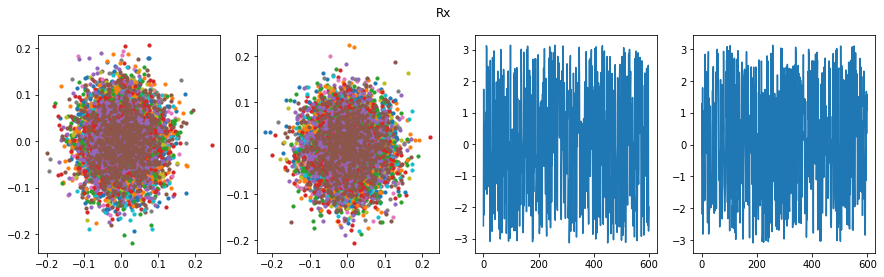

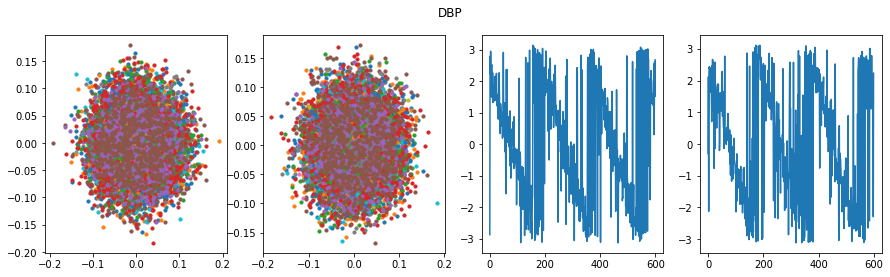

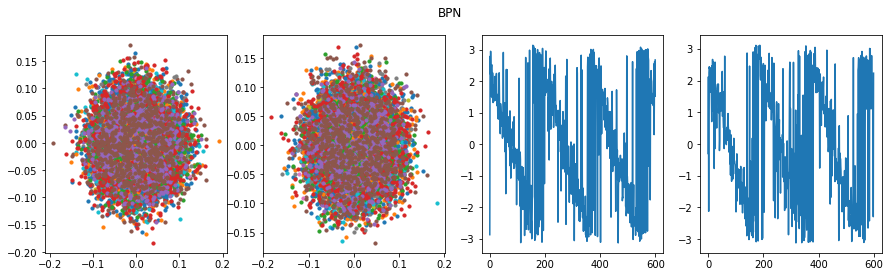

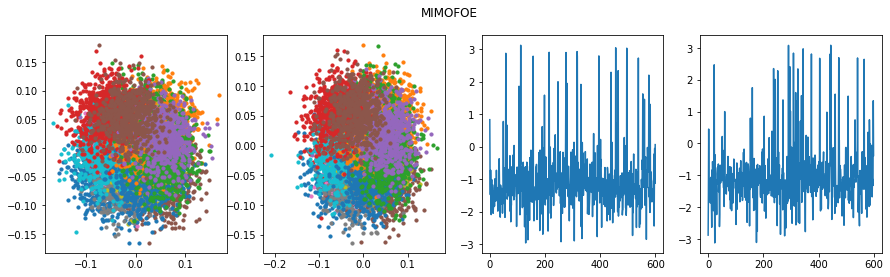

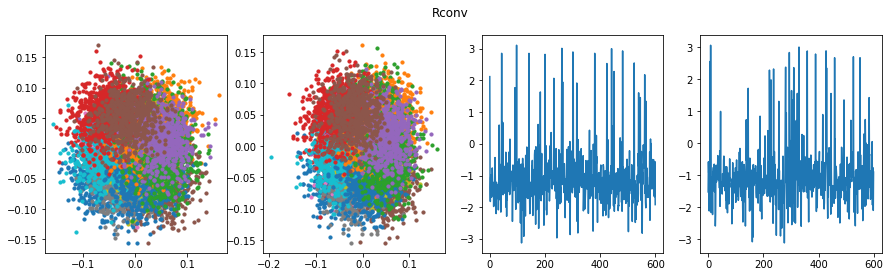

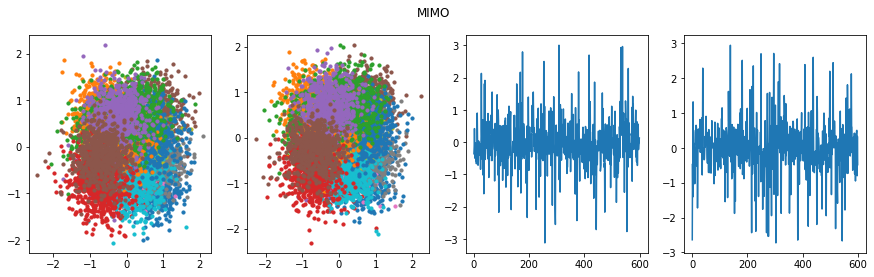

In [58]:
base.show_fig(sig_list, data_sml.x, ['Rx','DBP','BPN','MIMOFOE','Rconv','MIMO'])

In [84]:
from commplax import op
x = np.arange(100)

## Generate data: power + sps

## Add Data + Change training Scheme

1. Meta NN 结构调整
2. Adaptive filter structure anf theory
3. whole pipeline rethink
4. 整理前面的idea和实验结果